Ejercicios Unidad 1

1. Elija una de las imágenes color que tomó para la clase y aplique separación de canales y elija un método para transformarla en escala de grises. Muestre por pantalla los resultados obtenidos. 

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
img = cv2.imread("glasses_pictures/foto (8).jpg")

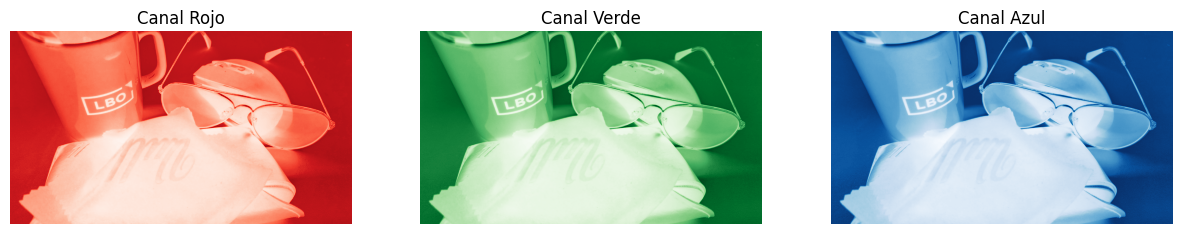

In [3]:
R, G, B = img[:, :, 0], img[:, :, 1], img[:, :, 2]
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(R, cmap='Reds')
axs[0].set_title('Canal Rojo')
axs[0].axis('off')

axs[1].imshow(G, cmap='Greens')
axs[1].set_title('Canal Verde')
axs[1].axis('off')

axs[2].imshow(B, cmap='Blues')
axs[2].set_title('Canal Azul')
axs[2].axis('off')

plt.show()

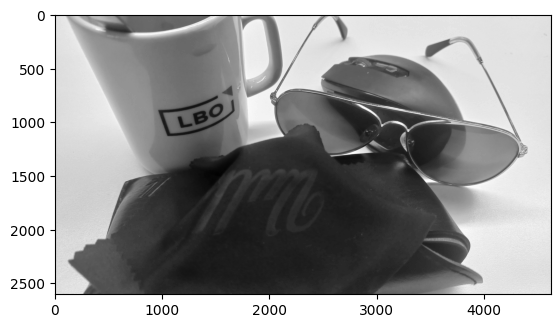

In [4]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap='gray')

2. Con las fotografías pedidas por la cátedra la clase pasada (la foto de objetos con fondo liso, y fotos del mismo producto en un contexto más complejo) usar los métodos de extracción de características (esos anteriores al Deep Learning) para encontrar la ubicación del producto dentro de la imagen. 

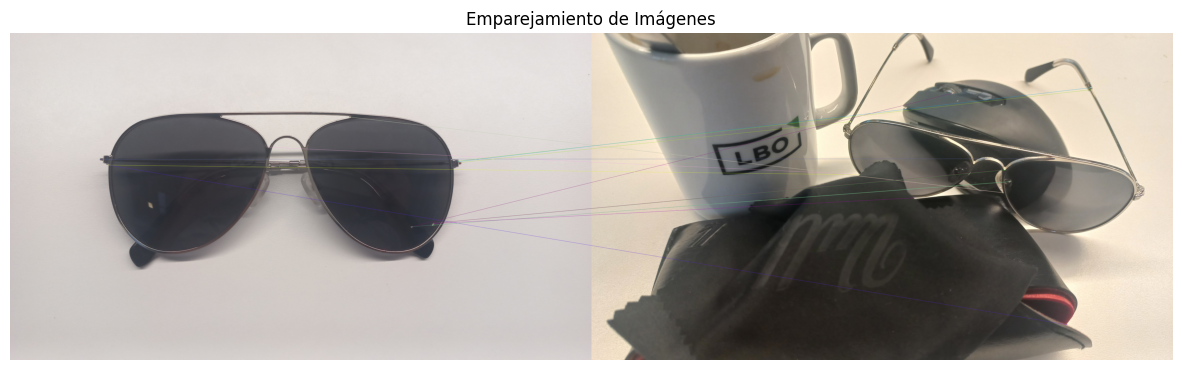

In [5]:
image1 = cv2.imread('glasses_pictures/foto (1).jpg')
image2 = cv2.imread('glasses_pictures/foto (8).jpg')

# Inicializar ORB
orb = cv2.ORB_create()

# Detectar keypoints y calcular descriptores
keypoints1, descriptors1 = orb.detectAndCompute(image1, None)
keypoints2, descriptors2 = orb.detectAndCompute(image2, None)

# Crear un objeto BFMatcher para encontrar las coincidencias
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Encontrar coincidencias
matches = bf.match(descriptors1, descriptors2)

# Ordenar las coincidencias en orden de distancia (cuanto más baja, mejor)
matches = sorted(matches, key=lambda x:x.distance)

# Dibujar las primeras 15 coincidencias
matched_img = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches[:15], outImg=None, flags=2)

# Ajustar el tamaño de la figura de matplotlib
plt.figure(figsize=(15, 20))
plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
plt.title('Emparejamiento de Imágenes')
plt.axis('off')
plt.show()

3. Para leer un paper, conviene arrancar leyendo el abstract, luego hacer una lectura por los títulos de las distintas secciones, prestar atención a las imágenes y su texto asociado, y leer con detalle la conclusión. 
    
    Se dividirá la comisión completa en 5 grupos de dialogo, cada grupo tomará un paper diferente de los que se muestran en la sección “Técnicas de extracción de características mediante aprendizaje profundo.” Les proponemos hacer una primera lectura del mismo. Luego de la misma un par de valientes del grupo dará una breve presentación de los mismos.
    
    [01_superpoint.pdf](https://drive.google.com/file/d/1tx6GrL1Cr-LnQBSH1K9xffPxbasQugE9/view?usp=drive_web)
    
    [02_d2net.pdf](https://drive.google.com/file/d/1-b07QhWcRdQWYhZxQ6wY97KN_Oiu1M8L/view?usp=drive_web)
    
    [03_NeurIPS.pdf](https://drive.google.com/file/d/1su2irZiTg1brgTUaAGxgUquHzZDzp_7d/view?usp=drive_web)
    
    [04_liu2018.pdf](https://drive.google.com/file/d/1IQT7nKAHXQD7opxk7ws-mLok7NGdXe09/view?usp=drive_web)
    
    [05_Zhang_Deep_Graphical_Feature_Learning.pdf](https://drive.google.com/file/d/15mFrmQvKmCFX_WeFNYfticSOrOKcKVTL/view?usp=drive_web)

4. Con los videos de youtube.com de cámara fija pedidos para esta clase, aplicar los algoritmos de detección de movimiento vistos en la teoría.

5. Genere un video en un patio o en un hall de edificio donde en un principio se vea vacío y luego aparezca una persona. Mediante los métodos de motion detection (sin usar deep learning) logre una detección de la persona cuando entra al cuadro suponiendo la utilidad para una cámara de seguridad. 
Luego sobre el mismo video aplique los algoritmos de flujo denso y disperso que se mostraron en clase. 
Escriba una reflexión sobre los resultados en el formato md dentro del Jupyter Notebook.

In [6]:
def process_frame_difference_full(new_image, prev_image, **kwargs):
    # Convertir las imágenes a escala de grises
    new_gray = cv2.cvtColor(new_image, cv2.COLOR_RGB2GRAY)
    prev_gray = cv2.cvtColor(prev_image, cv2.COLOR_RGB2GRAY)

    # Calcular la diferencia absoluta entre los fotogramas actual y anterior
    frame_diff = cv2.absdiff(new_gray, prev_gray)

    # Normalizar la imagen de diferencia
    norm_diff = cv2.normalize(frame_diff, None, 0, 255, cv2.NORM_MINMAX)

    # Umbralizar la imagen para resaltar las diferencias
    _, thresh = cv2.threshold(norm_diff, 30, 255, cv2.THRESH_BINARY)

    # Dilatar la imagen umbralizada para mejorar la detección de contornos
    kernel = np.ones((5,5),np.uint8)
    dilated = cv2.dilate(thresh, kernel, iterations = 1)

    # Convertir la imagen dilatada a formato adecuado para findContours
    dilated = dilated.astype(np.uint8)

    # Encontrar contornos en la imagen dilatada
    contours, _ = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Dibujar cuadros delimitadores alrededor de los contornos
    if kwargs.get('draw_mode', 0) == 0:
      result_image = draw_contours(new_image, contours)
    elif kwargs.get('draw_mode', 0) == 1:
      result_image = draw_contours(thresh, contours)

    return result_image
def process_sparse_optical_flow(new_image, prev_image):
    # Preparamos las imagenes de trabajo
    new_gray = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
    
    # Verificar si la imagen previa es en color antes de convertirla a escala de grises
    if len(prev_image.shape) == 3:  # Verificar si tiene 3 dimensiones (es una imagen en color)
        prev_gray_image = cv2.cvtColor(prev_image, cv2.COLOR_BGR2GRAY)
    else:  # Si no tiene 3 dimensiones, probablemente ya esté en escala de grises
        prev_gray_image = prev_image

    # Verificar si ya se han detectado las características de Shi-Tomasi
    if not hasattr(process_sparse_optical_flow, "shi_tomasi_done"):
        # Definir parámetros para la detección de esquinas de Shi-Tomasi
        feature_params = dict(maxCorners=300, qualityLevel=0.2, minDistance=2, blockSize=7)
        # Detectar puntos característicos en la imagen
        process_sparse_optical_flow.prev_points = cv2.goodFeaturesToTrack(new_gray, mask=None, **feature_params)
        # Crear una máscara para dibujar el flujo óptico
        process_sparse_optical_flow.mask = np.zeros_like(new_image)
        # Marcar que se ha completado la detección de Shi-Tomasi
        process_sparse_optical_flow.shi_tomasi_done = True

    # Continuar si se ha completado la detección de Shi-Tomasi
    if process_sparse_optical_flow.shi_tomasi_done:
        prev_points = process_sparse_optical_flow.prev_points
        mask = process_sparse_optical_flow.mask

    # Parámetros para el flujo óptico de Lucas-Kanade
    lk_params = dict(winSize=(15, 15), maxLevel=2,
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    # Calcular el flujo óptico de Lucas-Kanade
    new_points, status, error = cv2.calcOpticalFlowPyrLK(prev_gray_image, new_gray, prev_points, None, **lk_params)
    # Filtrar puntos buenos
    good_old = prev_points[status == 1]
    good_new = new_points[status == 1]
    color = (0, 255, 0)  # Color para el dibujo
    # Dibujar el movimiento (flujo óptico)
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.astype(int).ravel()
        c, d = old.astype(int).ravel()
        mask = cv2.line(mask, (a, b), (c, d), color, 2)
        new_image = cv2.circle(new_image, (a, b), 3, color, -1)

    # Combinar la imagen actual con las líneas de flujo óptico dibujadas
    output = cv2.add(new_image, mask)
    # Actualizar puntos para el siguiente cuadro
    process_sparse_optical_flow.prev_points = good_new.reshape(-1, 1, 2)
    return output

# Función para procesar el flujo óptico denso
def process_dense_optical_flow(new_image, prev_image):
    # Convierte la nueva imagen a escala de grises
    gray = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)

    if not hasattr(process_dense_optical_flow, "init_done"):
        process_dense_optical_flow.prev_gray = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
        process_dense_optical_flow.mask = np.zeros_like(new_image)
        process_dense_optical_flow.mask[..., 1] = 255
        process_dense_optical_flow.init_done = True

    if process_dense_optical_flow.init_done:
        prev_gray = process_dense_optical_flow.prev_gray
        mask = process_dense_optical_flow.mask

    # Calcula el flujo óptico
    flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    # Computa magnitud y ángulo de los vectores 2D
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    # Establece el tono de la imagen según la dirección del flujo óptico
    mask[..., 0] = angle * 180 / np.pi / 2
    # Establece el valor de la imagen según la magnitud del flujo óptico
    mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    # Convierte de HSV a RGB
    rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)
    # Actualiza la imagen previa a gris
    process_dense_optical_flow.prev_grayprev_gray = gray.copy()
    return rgb

### Elección de video

In [7]:
path = "walking_videos\\walking(3).mp4"

### Sin deep learning

In [8]:
captura = cv2.VideoCapture(path)
ret, prev = captura.read()
prev = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
while (captura.isOpened()):
  ret, imagen = captura.read()
  if ret == True:
    gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)        
    frame_diff = cv2.absdiff(gray, prev)     
    ret, thres = cv2.threshold(frame_diff, 35, 255, cv2.THRESH_BINARY)

    prev = gray.copy()       
    cv2.imshow('original',imagen)    
    cv2.imshow('foregroundMask',thres)
    if cv2.waitKey(30) == ord('s'):
      break
  else: break
captura.release()
cv2.destroyAllWindows()

In [12]:
captura = cv2.VideoCapture(path)
ret, prev = captura.read()
prev = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
while (captura.isOpened()):
  ret, imagen = captura.read()
  if ret == True:
    gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)        
    frame_diff = cv2.absdiff(gray, prev)     
    ret, thresh = cv2.threshold(frame_diff, 35, 255, cv2.THRESH_BINARY)

    prev = gray.copy()       
    
    kernel = np.ones((5,5),np.uint8)
    dilated = cv2.dilate(thresh, kernel, iterations = 1)

    dilated = dilated.astype(np.uint8)

    contours, _ = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
      area = cv2.contourArea(cnt)
      if area > 1000:
        cv2.drawContours(imagen, [cnt], 0, (0,255,0), 2)

    cv2.imshow('original',imagen)
    if cv2.waitKey(30) == ord('s'):
      break
  else: break
captura.release()
cv2.destroyAllWindows()

: 

In [ ]:
captura = cv2.VideoCapture(path)
ret, prev = captura.read()
prev = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
while (captura.isOpened()):
  ret, imagen = captura.read()
  if ret == True:
    gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)        
    frame_diff = cv2.absdiff(gray, prev)     
    ret, thresh = cv2.threshold(frame_diff, 35, 255, cv2.THRESH_BINARY)

    prev = gray.copy()       
    
    kernel = np.ones((5,5),np.uint8)
    dilated = cv2.dilate(thresh, kernel, iterations = 1)

    dilated = dilated.astype(np.uint8)

    contours, _ = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
      area = cv2.contourArea(cnt)
      if area > 1000:
        cv2.drawContours(imagen, [cnt], 0, (0,255,0), 2)

    cv2.imshow('original',imagen)
    if cv2.waitKey(30) == ord('s'):
      break
  else: break
captura.release()
cv2.destroyAllWindows()

In [ ]:

    prev = gray.copy()       
    
    kernel = np.ones((5,5),np.uint8)
    dilated = cv2.dilate(thresh, kernel, iterations = 1)

    dilated = dilated.astype(np.uint8)

    contours, _ = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
      area = cv2.contourArea(cnt)
      if area > 1000:
        cv2.drawContours(imagen, [cnt], 0, (0,255,0), 2)

    cv2.imshow('original',imagen)
    if cv2.waitKey(30) == ord('s'):
      break
  else: break
captura.release()
cv2.destroyAllWindows()

In [ ]:
    kernel = np.ones((5,5),np.uint8)
    dilated = cv2.dilate(thresh, kernel, iterations = 1)

    dilated = dilated.astype(np.uint8)

    contours, _ = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
      area = cv2.contourArea(cnt)
      if area > 1000:
        cv2.drawContours(imagen, [cnt], 0, (0,255,0), 2)

    cv2.imshow('original',imagen)
    if cv2.waitKey(30) == ord('s'):
      break
  else: break
captura.release()
cv2.destroyAllWindows()

### Detección de movimiento con Sparse Optical Flow

In [10]:
captura = cv2.VideoCapture(path)
ret, prev = captura.read()
prev = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)

output_path = "video_con_efectos.avi"
fourcc = cv2.VideoWriter_fourcc(*'XVID')
fps = captura.get(cv2.CAP_PROP_FPS)
width = int(captura.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(captura.get(cv2.CAP_PROP_FRAME_HEIGHT))
salida = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

while (captura.isOpened()):
    ret, imagen = captura.read()
    if ret == True:  
        frame_diff = process_sparse_optical_flow(imagen, prev)

        prev = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

        salida.write(frame_diff)

        cv2.imshow('original', imagen)    
        cv2.imshow('foregroundMask', frame_diff)
        
        if cv2.waitKey(30) == ord('s'):
            break
    else:
        break

    # Actualizar prev con el fotograma actual
    prev = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

captura.release()
salida.release()
cv2.destroyAllWindows()

### Detección de movimiento con Dense Optical Flow

In [11]:
captura = cv2.VideoCapture(path)
ret, prev = captura.read()
prev = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)

output_path = "video_con_efectos.avi"
fourcc = cv2.VideoWriter_fourcc(*'XVID')
fps = captura.get(cv2.CAP_PROP_FPS)
width = int(captura.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(captura.get(cv2.CAP_PROP_FRAME_HEIGHT))
salida = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

while (captura.isOpened()):
    ret, imagen = captura.read()
    if ret == True:  
        frame_diff = process_dense_optical_flow(imagen, prev)

        prev = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

        salida.write(frame_diff)

        cv2.imshow('original', imagen)    
        cv2.imshow('foregroundMask', frame_diff)
        
        if cv2.waitKey(30) == ord('s'):
            break
    else:
        break

    # Actualizar prev con el fotograma actual
    prev = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

captura.release()
salida.release()
cv2.destroyAllWindows()

Se pueden notar buenos resultados en la detección de personas y puntos sin necesidad de usar CNN. También se puede notar que el método de detección de movimiento con Sparse Optical Flow es más rápido que el método de detección de movimiento con Dense Optical Flow. En el caso de Sparse Optical Flow se puede notar que se detectan menos puntos que en el caso de Dense Optical Flow, pero se puede notar que los puntos detectados son más precisos. En el caso de Dense Optical Flow se puede notar que se detectan más puntos que en el caso de Sparse Optical Flow, pero se puede notar que los puntos detectados son menos precisos.

6. Explique cuál es diferencia entre localización de objetos y clasificación de imágenes. Muestre ejemplos de ello.

La diferencia entre la clasificación y la localización de objetos radica, como sus nombres lo indican, en que la clasificación de imágenes se encarga de determinar a qué clase pertenece una imagen, mientras que la localización de objetos se encarga de determinar dónde se encuentra un objeto en una imagen.

### Clasificación de imágenes
Uno de los casos mas populares para la clasificación de imágenes consiste en entrenar a un modelo para diferenciar imaágenes de perros o gatos. En este caso, el modelo a entrenar debe ser capaz de aprender las features necesarias de cada animal para poder determinar en una imagen nueva si la misma contiene un perro o un gato. Es un típico caso de clasificación dado que lo que pretendemos que determine el modelo es a qué clase pertenece la imagen.

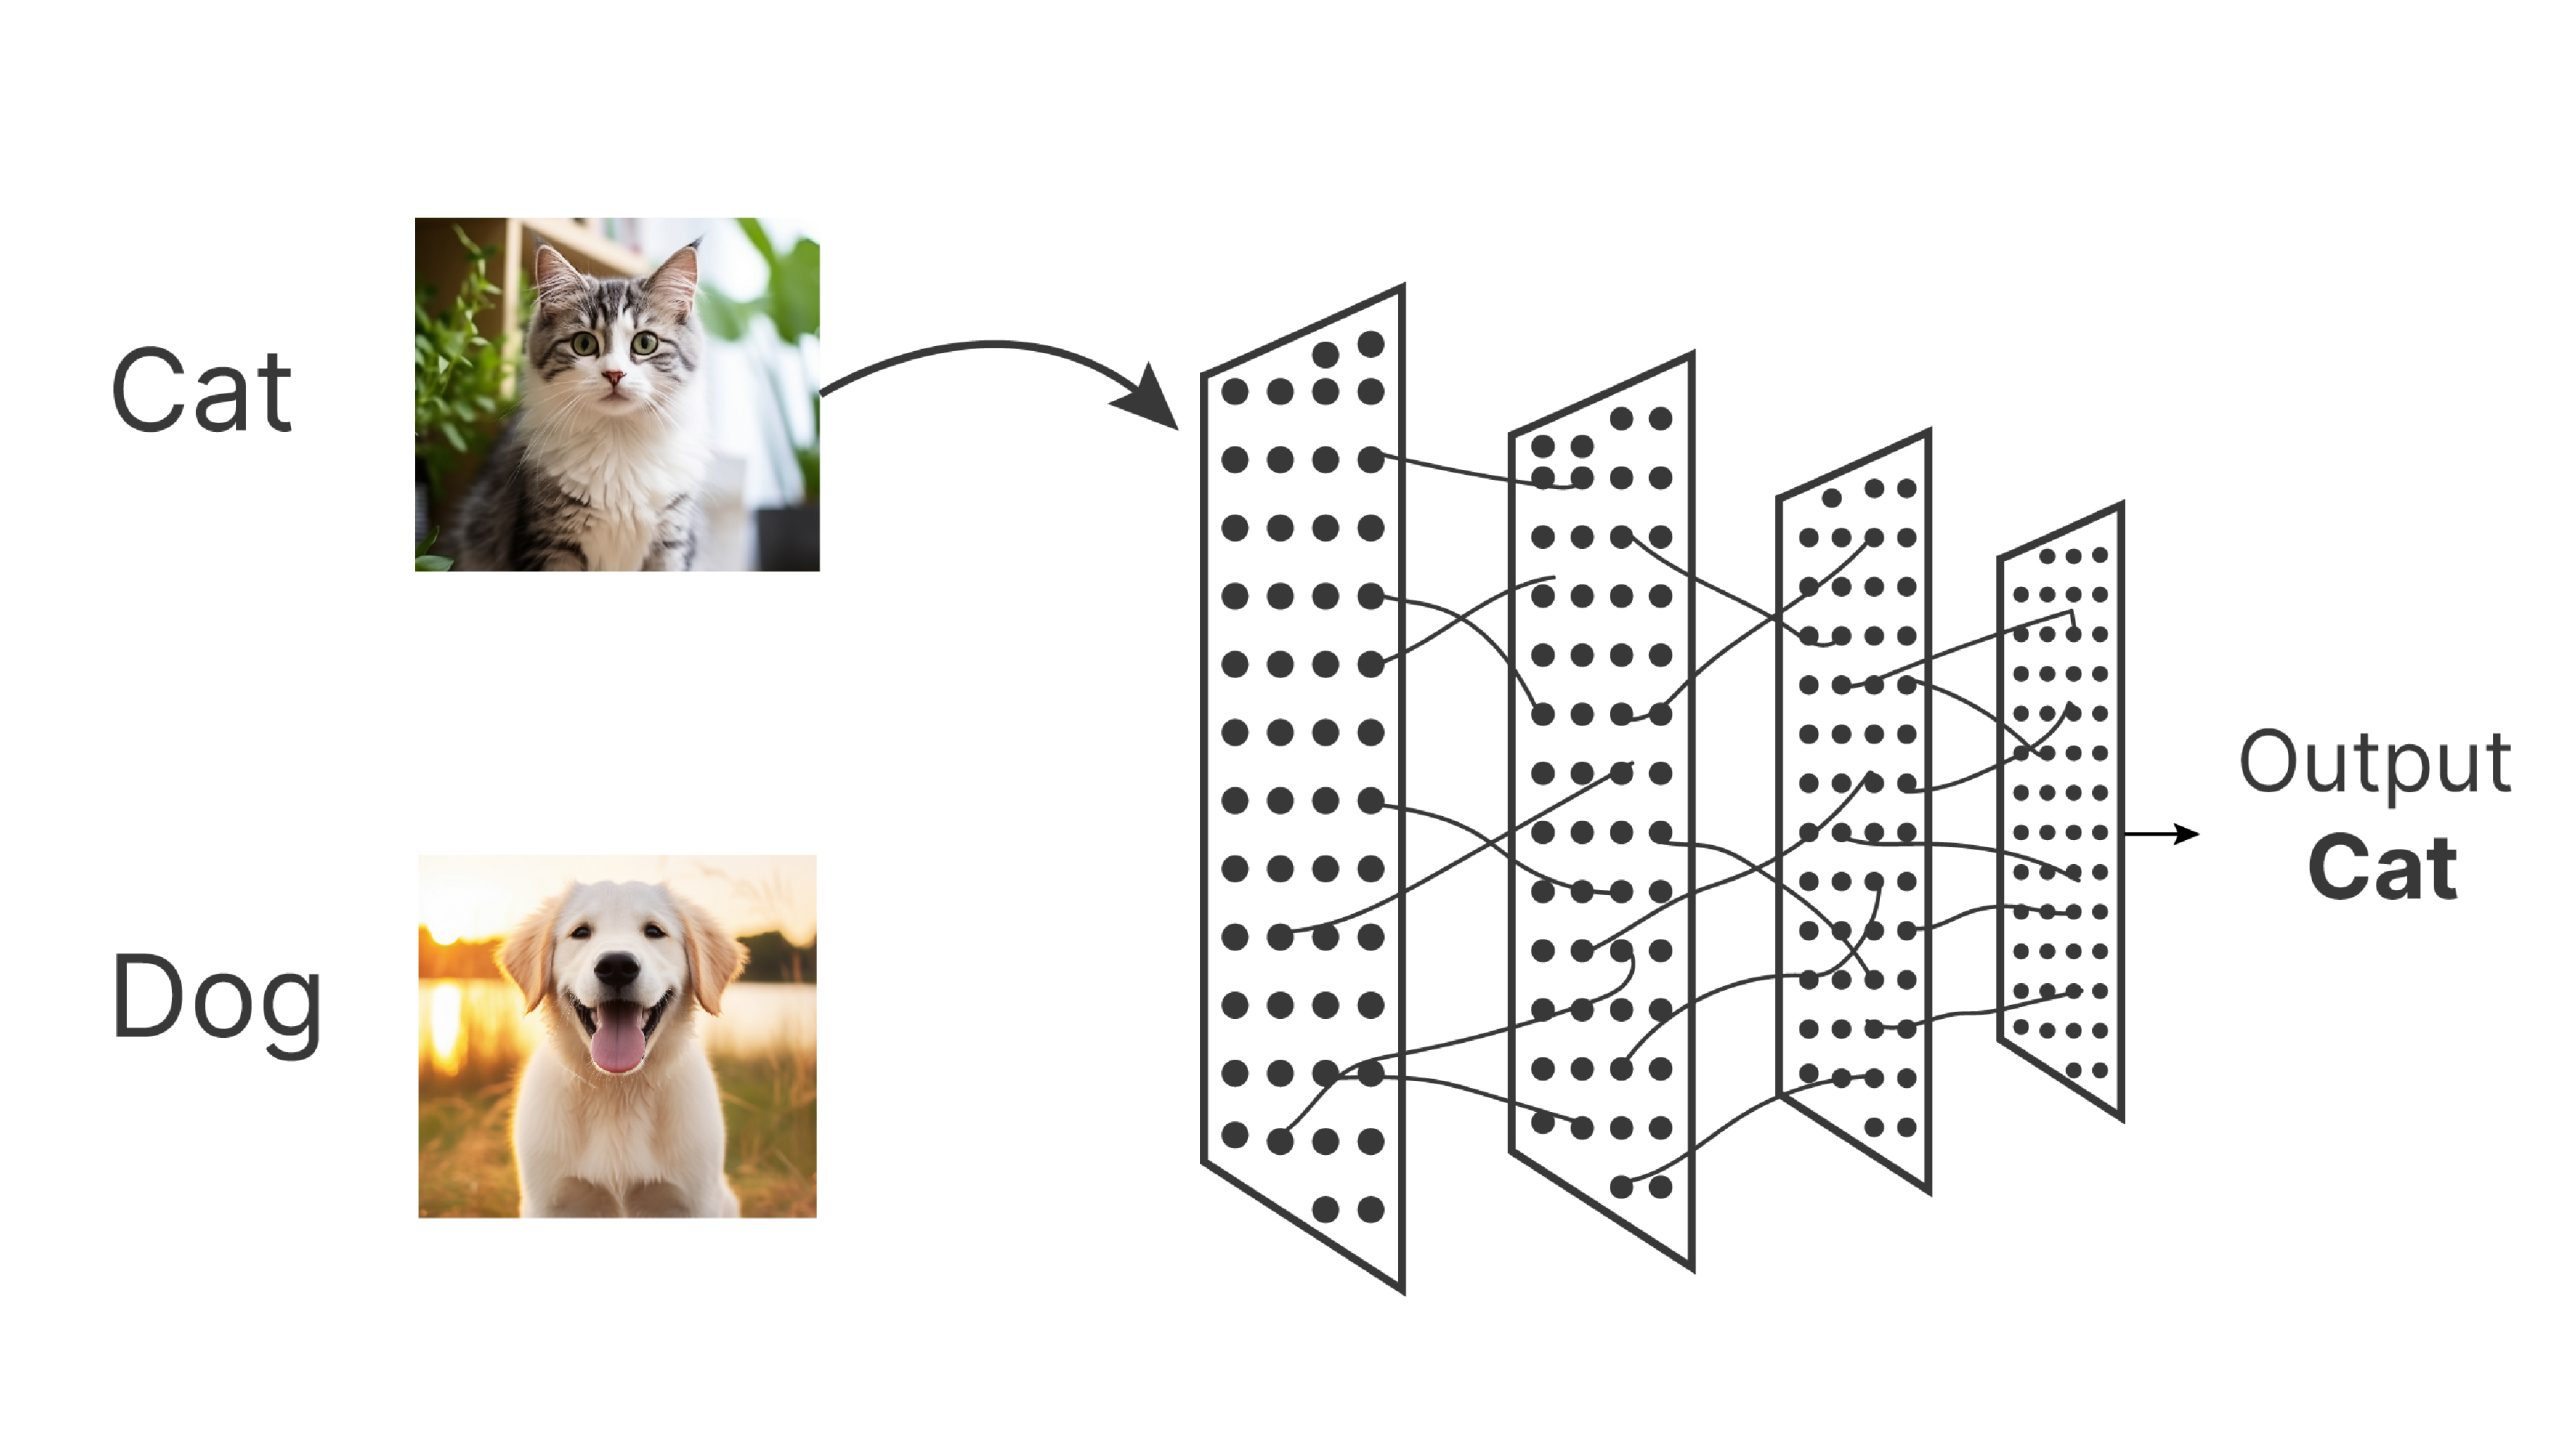


### Localización de objetos
En el caso de la localización de objetos, el modelo debe ser capaz de determinar dónde se encuentra un objeto en una imagen. Es común usar modelos preentrenados para la detección de objetos y luego ajustarlos a las necesidades del problema. En este caso, el modelo debe ser capaz de determinar las coordenadas de un cuadro que contenga al objeto en cuestión. Uno de los ejemplos mas clásicos es el software de los automóviles autónomos, que deben ser extremadamente capaces de no solo detectar sino también clasificar y posicionar distintos tipos de objetos para tomar decisiones.

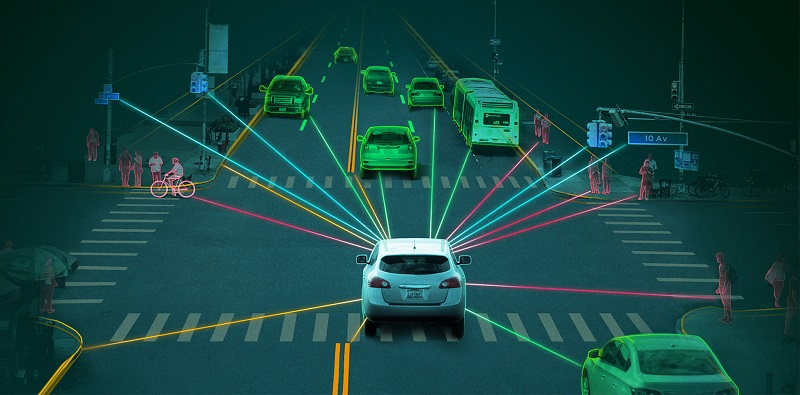